In [40]:
%load_ext autoreload
%autoreload 2
%aimport mcfost
%matplotlib inline
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterExponent
from numpy import unravel_index
import astropy.units as unit
import pysynphot
import os
import math
from sh import gunzip
from numpy import inf
import matplotlib.colors as colors

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
def bandavg(file_dir):
    px=256
    py=256
    c=2.99792*10**14
    jy=10**26
    psf_scale=0.0208 ##arcsecs/pixel
    xpix=(np.arange ((-px/2)+30, (px/2)-30, 1))*psf_scale
    ypix=(np.arange ((-px/2)+30, (px/2-30), 1))*psf_scale
    sq_as_per_pix=psf_scale**2
    model_in=mcfost.ModelResults(file_dir)
    wav=list(model_in._wavelengths_lookup.values())
    fig_path=file_dir+'band_avg.pdf'
    l=len(wav)
    figr=[]
    sst_band=np.zeros((256,256),dtype=float)
    I_band=np.zeros((256,256),dtype=float)
    Q_band=np.zeros((256,256),dtype=float)
    U_band=np.zeros((256,256),dtype=float)
    for i in range (l):
        im=model_in.images[wav[i]]
        lam=float(wav[i]) #in microns#
        
        I=np.reshape(im.data[0,0],(px,py))
        Q=np.reshape(im.data[1,0],(px,py))
        U=np.reshape(im.data[2,0],(px,py))
        sst=np.reshape(im.data[5,0],(px,py))
        
        sst_jy=(sst/c)*(lam**2)*jy
        sst_band=sst_band+sst_jy
        
        I_jy=(I/c)*(lam**2)*jy
        I_band=I_band+I_jy
        
        Q_jy=(Q/c)*(lam**2)*jy
        Q_band=Q_band+Q_jy
        
        U_jy=(U/c)*(lam**2)*jy
        U_band=U_band+U_jy
        
    sst_avg=sst_band/l
    I_avg=I_band/l
    Q_avg=Q_band/l
    U_avg=U_band/l
        
    hdu = fits.PrimaryHDU(sst_avg.astype(np.float64))
    hdul = fits.HDUList([hdu])
    hdul.writeto(file_dir+'sst_band.fits',overwrite=True)
    hdu = fits.PrimaryHDU(I_avg.astype(np.float64))
    hdul = fits.HDUList([hdu])
    hdul.writeto(file_dir+'I_band.fits',overwrite=True)
    hdu = fits.PrimaryHDU(Q_avg.astype(np.float64))
    hdul = fits.HDUList([hdu])
    hdul.writeto(file_dir+'Q_band.fits',overwrite=True)
    hdu = fits.PrimaryHDU(U_avg.astype(np.float64))
    hdul = fits.HDUList([hdu])
    hdul.writeto(file_dir+'U_band.fits',overwrite=True)
        
    fig = plt.figure(figsize=(25, 12))
    ax1=fig.add_subplot(141)
    ax1.yaxis.set_ticks_position('both')
    ax1.xaxis.set_ticks_position('both')
    ax1.minorticks_on()
    ax1.tick_params(which='both', direction='in', width=0.5, labelsize=16)
    im1=ax1.imshow(I_avg.astype(np.float64)[58:198,58:198]/1000,cmap='plasma',extent=[np.min(xpix),np.max(xpix),np.max(ypix),np.min(ypix)])
    ax1.invert_yaxis()
    ax1.set_ylabel('arcsec',fontsize=18)
    ax1.set_xlabel('arcsec',fontsize=18)
    ax1.set_title('$Star$',fontsize=18)
    cb = fig.colorbar(im1,orientation='vertical',shrink=0.4)
    cb.set_label("mJy",fontsize=18)
    cb.ax.tick_params(labelsize=18)

    ax2=fig.add_subplot(142)
    ax2.yaxis.set_ticks_position('both')
    ax2.xaxis.set_ticks_position('both')
    ax2.minorticks_on()
    ax2.tick_params(which='both', direction='in', width=0.5, labelsize=16)
    im2=ax2.imshow(sst_avg.astype(np.float64)[58:198,58:198]/sq_as_per_pix*1000,cmap='plasma',extent=[np.min(xpix),np.max(xpix),np.max(ypix),np.min(ypix)])
    ax2.invert_yaxis()
    ax2.set_ylabel('arcsec',fontsize=18)
    ax2.set_xlabel('arcsec',fontsize=18)
    ax2.set_title('$Scattered starlight$',fontsize=18)
    cb = fig.colorbar(im2,orientation='vertical',shrink=0.4)
    cb.set_label("mJy/arcsec^2",fontsize=18)
    cb.ax.tick_params(labelsize=18)
        
    ax3=fig.add_subplot(143)
    ax3.yaxis.set_ticks_position('both')
    ax3.xaxis.set_ticks_position('both')
    ax3.minorticks_on()
    ax3.tick_params(which='both', direction='in', width=0.5, labelsize=16)
    im3=ax3.imshow(Q_avg.astype(np.float64)[58:198,58:198]/sq_as_per_pix*1000,cmap='plasma',extent=[np.min(xpix),np.max(xpix),np.max(ypix),np.min(ypix)])
    ax3.invert_yaxis()
    ax3.set_ylabel('arcsec',fontsize=18)
    ax3.set_xlabel('arcsec',fontsize=18)
    ax3.set_title('$Q$',fontsize=18)
    cb = fig.colorbar(im3,orientation='vertical',shrink=0.4)
    cb.set_label("mJy/arcsec^2",fontsize=18)
    cb.ax.tick_params(labelsize=18)

    ax4=fig.add_subplot(144)
    ax4.yaxis.set_ticks_position('both')
    ax4.xaxis.set_ticks_position('both')
    ax4.minorticks_on()
    ax4.tick_params(which='both', direction='in', width=0.5, labelsize=16)
    im4=ax4.imshow(U_avg.astype(np.float64)[58:198,58:198]/sq_as_per_pix*1000,cmap='plasma',extent=[np.min(xpix),np.max(xpix),np.max(ypix),np.min(ypix)])
    ax4.invert_yaxis()
    ax4.set_ylabel('arcsec',fontsize=18)
    ax4.set_xlabel('arcsec',fontsize=18)
    ax4.set_title('$U$',fontsize=18)
    cb = fig.colorbar(im4,orientation='vertical',shrink=0.4)
    cb.set_label("mJy/arcsec^2",fontsize=18)
    cb.ax.tick_params(labelsize=18)
        
    fig.subplots_adjust(hspace=0.1, wspace=0.45, top=0.9, right=0.95)
    fig.savefig(fig_path, format='pdf', bbox_inches='tight')
    figr.append(fig)
    return(figr)
        

In [177]:
f_dir='/Users/polaris/Onedrive-UA/OneDrive - University of Arizona/Debris-Disk-Modelling/Debris-Disk-Modelling/Eps-eri-Roman_pol/Simulations_paper/SPC_band/best_SED_Mie/'

[<Figure size 2500x1200 with 8 Axes>]

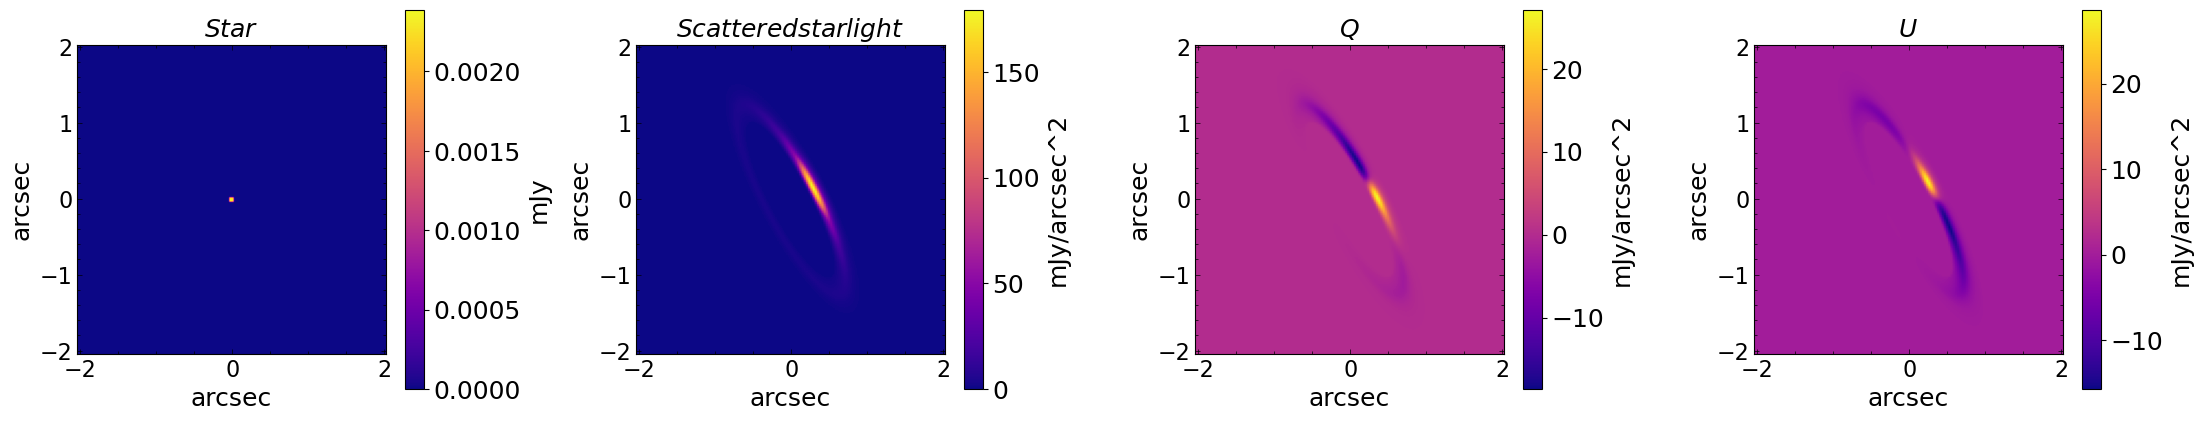

In [178]:
bandavg(f_dir)

In [179]:
px=py=256
psf_scale=0.0208 ##arcsecs/pixel
xpix=(np.arange ((-px/2)+53, (px/2)-53, 1))*psf_scale
ypix=(np.arange ((-px/2)+53, (px/2)-53, 1))*psf_scale
sq_as_per_pix=psf_scale**2

sst=fits.getdata(f_dir+'sst_band.fits')
Q=fits.getdata(f_dir+'Q_band.fits')
U=fits.getdata(f_dir+'U_band.fits')
#sst[sst == 0] = 'nan'
sst_lg=np.log10(sst.astype(np.float64)[128-75:128+75,128-75:128+75]/sq_as_per_pix*1000)

/var/folders/tz/b2jsht6d7nv7db1v7bt3645c0000gn/T/ipykernel_9677/2643428986.py:11: RuntimeWarning: divide by zero encountered in log10
  sst_lg=np.log10(sst.astype(np.float64)[128-75:128+75,128-75:128+75]/sq_as_per_pix*1000)


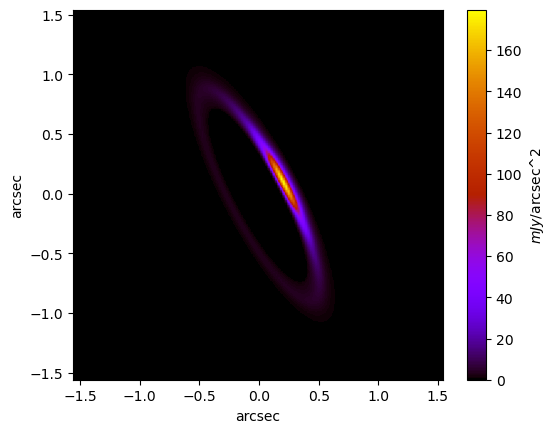

In [180]:
fig=plt.figure(dpi=100)
ax2=plt.subplot(111)
im2=ax2.imshow(sst.astype(np.float64)[128-75:128+75,128-75:128+75]/sq_as_per_pix*1000,
               extent=[np.min(ypix),np.max(ypix),np.max(xpix),np.min(xpix)],cmap='gnuplot')
ax2.invert_yaxis()
ax2.set_ylabel('arcsec')
ax2.set_xlabel('arcsec')
cb=plt.colorbar(im2,orientation='vertical')
cb.set_label("$mJy$/arcsec^2")
fig.savefig(f_dir+'scattered_light_hr4796.pdf', format='pdf', bbox_inches='tight')

In [181]:
q=Q/sst
u=U/sst
p=np.sqrt(q*q+u*u)
np.nanmax(p)

/var/folders/tz/b2jsht6d7nv7db1v7bt3645c0000gn/T/ipykernel_9677/344022279.py:1: RuntimeWarning: invalid value encountered in true_divide
  q=Q/sst
/var/folders/tz/b2jsht6d7nv7db1v7bt3645c0000gn/T/ipykernel_9677/344022279.py:2: RuntimeWarning: invalid value encountered in true_divide
  u=U/sst


1.0630145812734648

In [182]:
X, Y = np.mgrid[(0):(256):256j, (0):(256):256j]
positions = np.vstack([X.ravel(), Y.ravel()])
pos=np.transpose(positions)

Phi=np.arctan((pos[:,0]-128)/(pos[:,1]-128))
Phi_new=np.reshape(Phi,(256,256))

Q_phi=Q*np.cos(2*Phi_new)+U*np.sin(2*Phi_new)
U_phi=-Q*np.sin(2*Phi_new)+U*np.cos(2*Phi_new)
theta=0.5*np.arctan2(U,Q)
p=Q_phi/sst
p[np.isnan(p)]=0
np.max(p)

/var/folders/tz/b2jsht6d7nv7db1v7bt3645c0000gn/T/ipykernel_9677/3518025357.py:11: RuntimeWarning: invalid value encountered in true_divide
  p=Q_phi/sst


1.0401610697462391

In [183]:
qx, qy=np.unravel_index(np.argmax(Q_phi), Q_phi.shape)
prx, pry =np.unravel_index(np.argmax(p), p.shape)
npix=2
p_r_lin=np.mean(p[prx-npix:prx+npix,:],axis=0)
p_r_err=np.mean(np.std(p[prx-npix:prx+npix,:],axis=0))

In [158]:
np.max(p_r_lin)

0.3028888056014678

In [159]:
p_r_err 

0.0019852566912613445

In [167]:
np.max(Q_phi.astype(np.float64)/sq_as_per_pix*1000)

29.129272056698845

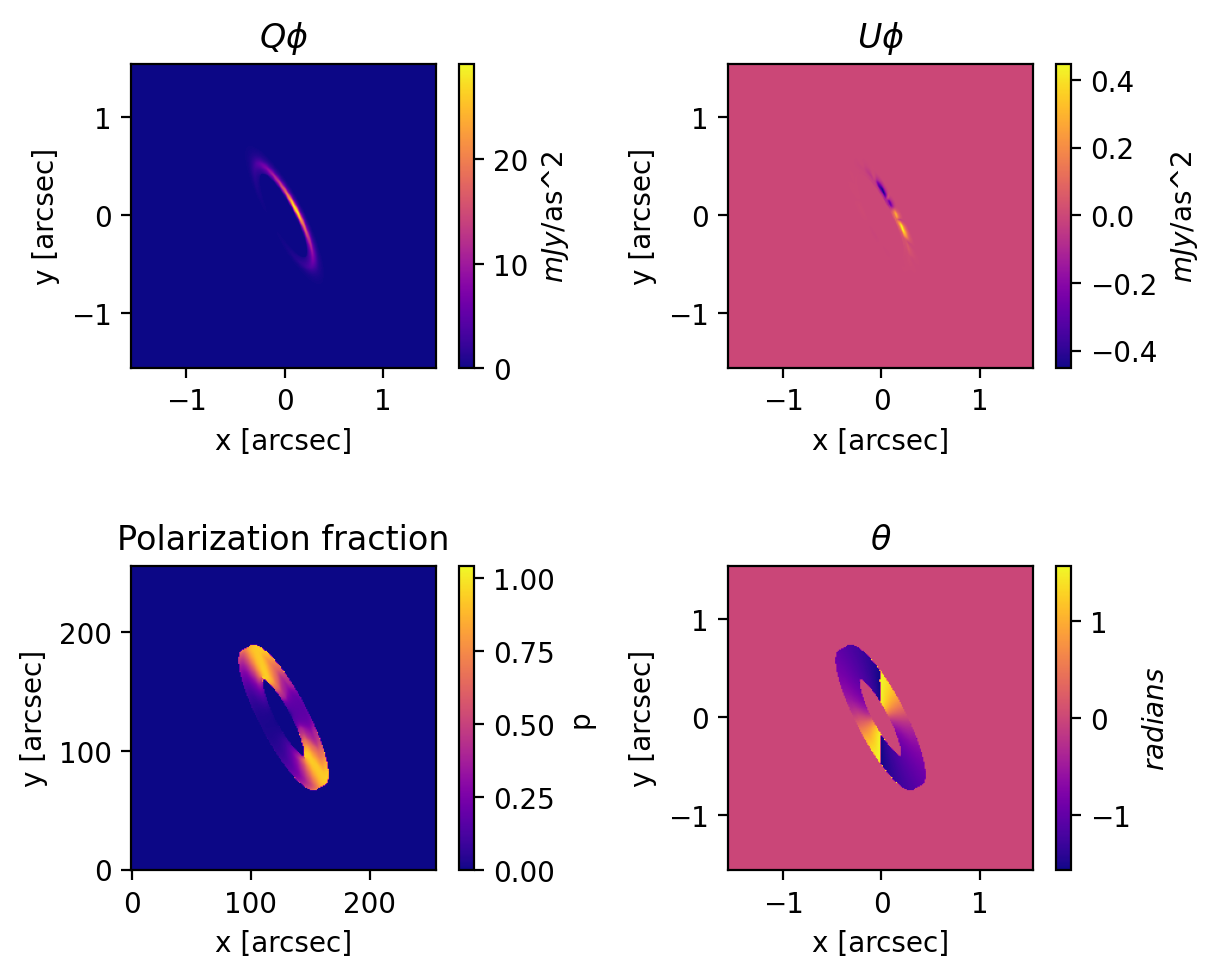

In [184]:
fig = plt.figure(dpi=200)
ax1=fig.add_subplot(221)
im1=ax1.imshow(Q_phi.astype(np.float64)/sq_as_per_pix*1000,cmap='plasma',extent=[np.min(xpix),np.max(xpix),np.max(ypix),np.min(ypix)])
ax1.invert_yaxis()
ax1.set_ylabel('y [arcsec]')
ax1.set_xlabel('x [arcsec]')
ax1.set_title(r'$Q\phi$')
cb = fig.colorbar(im1,orientation='vertical')
cb.set_label("$mJy$/as^2")
ax1.grid(False)

ax2=fig.add_subplot(222)
im2=ax2.imshow(U_phi.astype(np.float64)/sq_as_per_pix*1000,cmap='plasma',extent=[np.min(xpix),np.max(xpix),np.max(ypix),np.min(ypix)])
ax2.invert_yaxis()
ax2.set_ylabel('y [arcsec]')
ax2.set_xlabel('x [arcsec]')
ax2.set_title(r'$U\phi$')
cb = fig.colorbar(im2,orientation='vertical')
cb.set_label("$mJy$/as^2")
ax2.grid(False)


ax1=fig.add_subplot(223)
im1=ax1.imshow(p.astype(np.float64),cmap='plasma')
ax1.invert_yaxis()
ax1.set_ylabel('y [arcsec]')
ax1.set_xlabel('x [arcsec]')
ax1.set_title('Polarization fraction')
cb = fig.colorbar(im1,orientation='vertical')
cb.set_label("p")
ax1.grid(False)

ax1=fig.add_subplot(224)
im1=ax1.imshow(theta,cmap='plasma',extent=[np.min(xpix),np.max(xpix),np.max(ypix),np.min(ypix)])
ax1.invert_yaxis()
ax1.set_ylabel('y [arcsec]')
ax1.set_xlabel('x [arcsec]')
ax1.set_title(r'$\theta$')
cb = fig.colorbar(im1,orientation='vertical')
cb.set_label("$radians$")
ax1.grid(False)


fig.subplots_adjust(hspace=0.65, wspace=0.3, top=0.95, right=0.95)

In [185]:
#Roman IPAC estimations
# reference and target star from Os9
# ζ Pup V=2.25 
m_z=2.25
ph_z=128331610.410*2#ph/s

#47 UMa, V=5.04
m_u=5.04
ph_u=23707016.2206*2

In [186]:
# conversion to flux in Jy AB magnitude
F_z=3631*10**(m_z*(-0.4))
F_u=3631*10**(m_u*(-0.4))

In [187]:
# surface brightness calculation in mag/sqarcsec
# AB  zero magnitude reference has 2432 JY
SB=-2.5*np.log10(sst.astype(np.float64)/F_z)+2.5*np.log10(sq_as_per_pix)+m_z

/var/folders/tz/b2jsht6d7nv7db1v7bt3645c0000gn/T/ipykernel_9677/3594797925.py:3: RuntimeWarning: divide by zero encountered in log10
  SB=-2.5*np.log10(sst.astype(np.float64)/F_z)+2.5*np.log10(sq_as_per_pix)+m_z


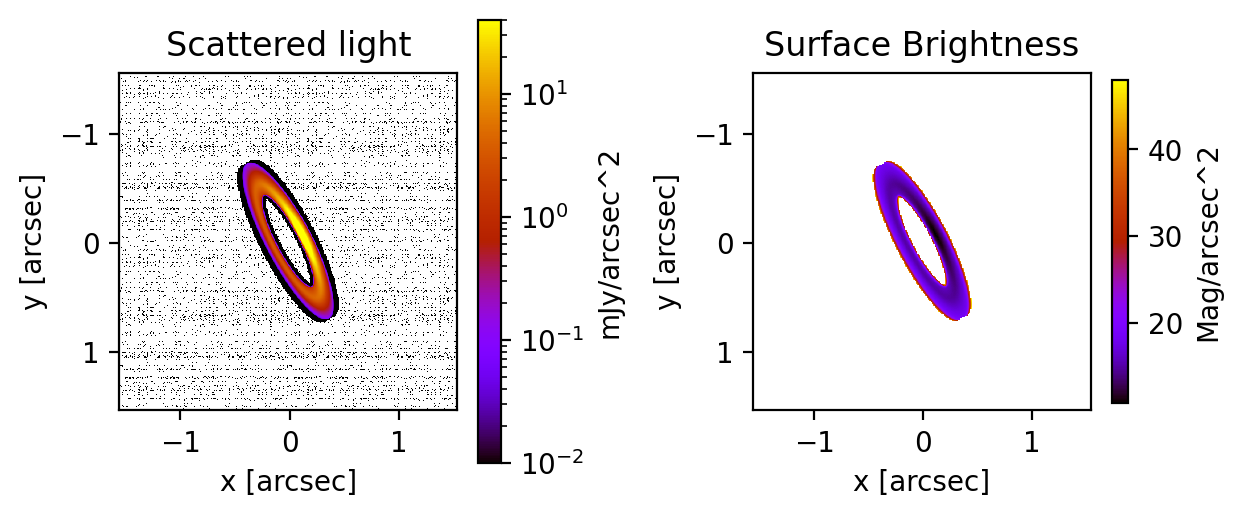

In [188]:
fig=plt.figure(dpi=200)
ax2=plt.subplot(121)
im2=ax2.imshow(sst.astype(np.float64)/sq_as_per_pix*1000,
               cmap='gnuplot',extent=[np.min(ypix),np.max(ypix),np.min(xpix),np.max(xpix)],norm=colors.LogNorm(vmin=1e-2, vmax=4e1))
ax2.invert_yaxis()
ax2.set_ylabel('y [arcsec]')
ax2.set_xlabel('x [arcsec]')
ax2.set_title('Scattered light')
cb=plt.colorbar(im2,orientation='vertical',shrink=0.55)
cb.set_label("mJy/arcsec^2")

ax2=plt.subplot(122)
im2=ax2.imshow(SB.astype(np.float64),
               cmap='gnuplot',extent=[np.min(ypix),np.max(ypix),np.min(xpix),np.max(xpix)])
ax2.invert_yaxis()
ax2.set_ylabel('y [arcsec]')
ax2.set_xlabel('x [arcsec]')
ax2.set_title('Surface Brightness')
cb=plt.colorbar(im2,orientation='vertical',shrink=0.4)
cb.set_label("Mag/arcsec^2")
fig.subplots_adjust(hspace=0.65, wspace=0.5, top=0.95, right=0.95)

/var/folders/tz/b2jsht6d7nv7db1v7bt3645c0000gn/T/ipykernel_9677/381385049.py:1: RuntimeWarning: divide by zero encountered in log10
  SB=-2.5*np.log10(sst.astype(np.float64)/F_z)+2.5*np.log10(sq_as_per_pix)+m_z


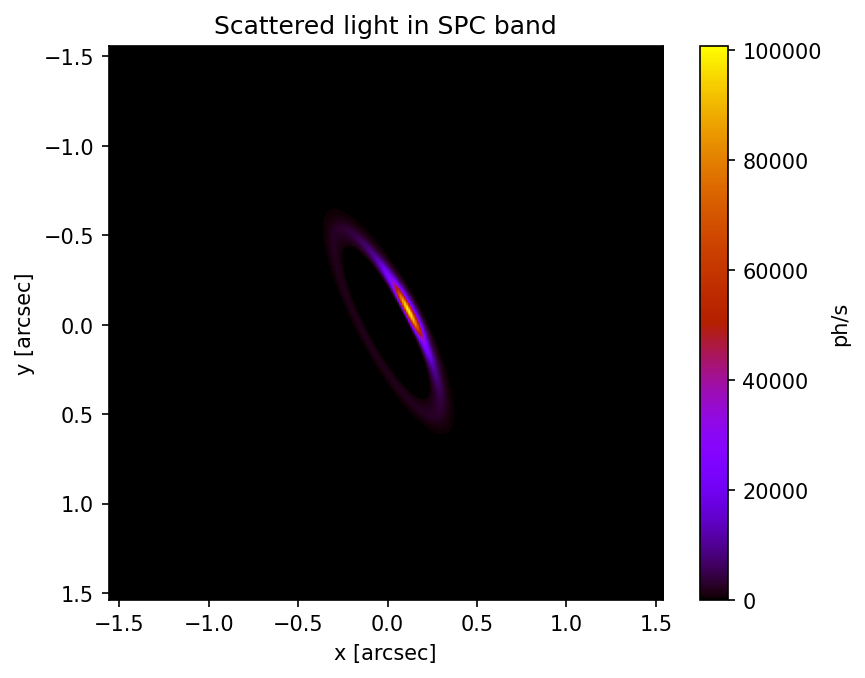

In [189]:
SB=-2.5*np.log10(sst.astype(np.float64)/F_z)+2.5*np.log10(sq_as_per_pix)+m_z
I=ph_z*10**(-0.4*(SB-m_z))
I[np.isnan(I)] = 0
hdu = fits.PrimaryHDU(I)
hdul = fits.HDUList([hdu])
#hdul.writeto(f_dir+'I_spc.fits',overwrite=True)

fig=plt.figure(dpi=150)
ax2=plt.subplot(111)
im2=ax2.imshow(I.astype(np.float64),
               cmap='gnuplot',extent=[np.min(ypix),np.max(ypix),np.min(xpix),np.max(xpix)])
ax2.invert_yaxis()
ax2.set_ylabel('y [arcsec]')
ax2.set_xlabel('x [arcsec]')
ax2.set_title('Scattered light in SPC band')
cb=plt.colorbar(im2,orientation='vertical')
cb.set_label("ph/s")
#fig.savefig(f_dir+'scattered_light.pdf', format='pdf', bbox_inches='tight')

In [174]:
I.max()

100757.24248806977

In [190]:
I0=(sst+Q)/2
I90=(sst-Q)/2
I45=(sst+U)/2
I135=(sst-U)/2

In [175]:
I0sb=-2.5*np.log10(I0.astype(np.float64)/F_z)+2.5*np.log10(sq_as_per_pix)+m_z
I0ph=ph_z*10**(-0.4*(I0sb-m_z))
I0ph[np.isnan(I0ph)] = 0

I90sb=-2.5*np.log10(I90.astype(np.float64)/F_z)+2.5*np.log10(sq_as_per_pix)+m_z
I90ph=ph_z*10**(-0.4*(I90sb-m_z))
I90ph[np.isnan(I90ph)] = 0

I45sb=-2.5*np.log10(I45.astype(np.float64)/F_z)+2.5*np.log10(sq_as_per_pix)+m_z
I45ph=ph_z*10**(-0.4*(I45sb-m_z))
I45ph[np.isnan(I45ph)] = 0

I135sb=-2.5*np.log10(I135.astype(np.float64)/F_z)+2.5*np.log10(sq_as_per_pix)+m_z
I135ph=ph_z*10**(-0.4*(I135sb-m_z))
I135ph[np.isnan(I135ph)] = 0

/var/folders/tz/b2jsht6d7nv7db1v7bt3645c0000gn/T/ipykernel_9677/542090191.py:1: RuntimeWarning: divide by zero encountered in log10
  I0sb=-2.5*np.log10(I0.astype(np.float64)/F_z)+2.5*np.log10(sq_as_per_pix)+m_z
/var/folders/tz/b2jsht6d7nv7db1v7bt3645c0000gn/T/ipykernel_9677/542090191.py:5: RuntimeWarning: divide by zero encountered in log10
  I90sb=-2.5*np.log10(I90.astype(np.float64)/F_z)+2.5*np.log10(sq_as_per_pix)+m_z
/var/folders/tz/b2jsht6d7nv7db1v7bt3645c0000gn/T/ipykernel_9677/542090191.py:9: RuntimeWarning: divide by zero encountered in log10
  I45sb=-2.5*np.log10(I45.astype(np.float64)/F_z)+2.5*np.log10(sq_as_per_pix)+m_z
/var/folders/tz/b2jsht6d7nv7db1v7bt3645c0000gn/T/ipykernel_9677/542090191.py:13: RuntimeWarning: divide by zero encountered in log10
  I135sb=-2.5*np.log10(I135.astype(np.float64)/F_z)+2.5*np.log10(sq_as_per_pix)+m_z


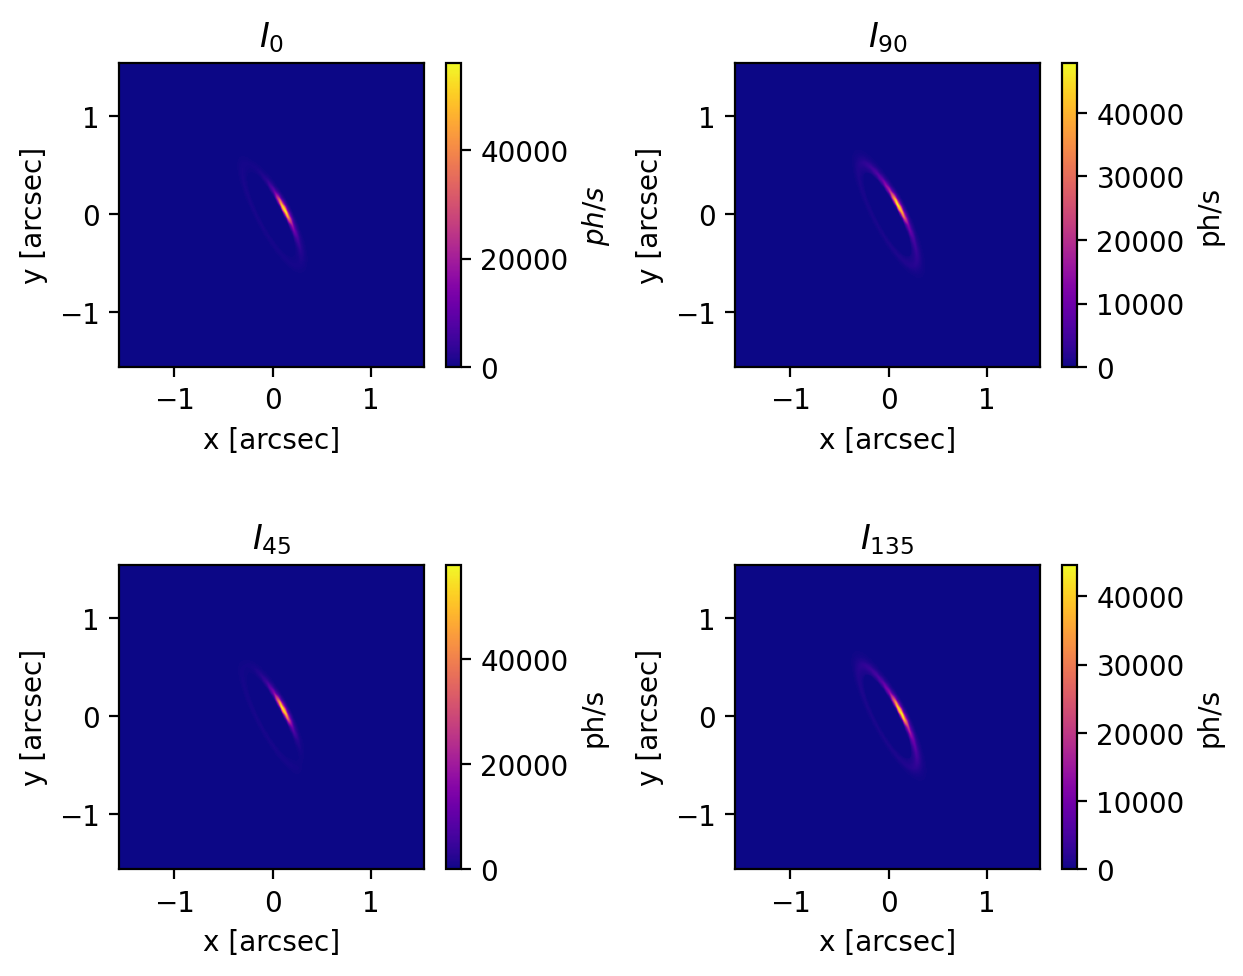

In [191]:
fig = plt.figure(dpi=200)
ax1=fig.add_subplot(221)
im1=ax1.imshow(I0ph,cmap='plasma',extent=[np.min(xpix),np.max(xpix),np.max(ypix),np.min(ypix)])
ax1.invert_yaxis()
ax1.set_ylabel('y [arcsec]')
ax1.set_xlabel('x [arcsec]')
ax1.set_title('$I_{0}$')
cb = fig.colorbar(im1,orientation='vertical')
cb.set_label("$ph/s$")
ax1.grid(False)

ax2=fig.add_subplot(222)
im2=ax2.imshow(I90ph,cmap='plasma',extent=[np.min(xpix),np.max(xpix),np.max(ypix),np.min(ypix)])
ax2.invert_yaxis()
ax2.set_ylabel('y [arcsec]')
ax2.set_xlabel('x [arcsec]')
ax2.set_title('$I_{90}$')
cb = fig.colorbar(im2,orientation='vertical')
cb.set_label("ph/s")
ax2.grid(False)

ax3=fig.add_subplot(223)
im3=ax3.imshow(I45ph,cmap='plasma',extent=[np.min(xpix),np.max(xpix),np.max(ypix),np.min(ypix)])
ax3.invert_yaxis()
ax3.set_ylabel('y [arcsec]')
ax3.set_xlabel('x [arcsec]')
ax3.set_title('$I_{45}$')
cb = fig.colorbar(im3,orientation='vertical')
cb.set_label("ph/s")
ax3.grid(False)

ax4=fig.add_subplot(224)
im4=ax4.imshow(I135ph,cmap='plasma',extent=[np.min(xpix),np.max(xpix),np.max(ypix),np.min(ypix)])
ax4.invert_yaxis()
ax4.set_ylabel('y [arcsec]')
ax4.set_xlabel('x [arcsec]')
ax4.set_title('$I_{135}$')
cb = fig.colorbar(im4,orientation='vertical')
cb.set_label("ph/s")
ax4.grid(False)
fig.subplots_adjust(hspace=0.65, wspace=0.4, top=0.95, right=0.95)

In [78]:
hdu = fits.PrimaryHDU(I0ph)
hdul = fits.HDUList([hdu])
hdul.writeto(f_dir+'I_0_spc.fits',overwrite=True)
hdu = fits.PrimaryHDU(I90ph)
hdul = fits.HDUList([hdu])
hdul.writeto(f_dir+'I_90_spc.fits',overwrite=True)
hdu = fits.PrimaryHDU(I45ph)
hdul = fits.HDUList([hdu])
hdul.writeto(f_dir+'I_45_spc.fits',overwrite=True)
hdu = fits.PrimaryHDU(I135ph)
hdul = fits.HDUList([hdu])
hdul.writeto(f_dir+'I_135_spc.fits',overwrite=True)

In [193]:
q=(I0ph-I90ph)/(I0ph+I90ph)
u=(I45ph-I135ph)/(I45ph+I135ph)
p=np.sqrt(q*q+u*u)
theta=0.5*np.arctan2(u,q)

/var/folders/tz/b2jsht6d7nv7db1v7bt3645c0000gn/T/ipykernel_9677/2120475084.py:1: RuntimeWarning: invalid value encountered in true_divide
  q=(I0ph-I90ph)/(I0ph+I90ph)
/var/folders/tz/b2jsht6d7nv7db1v7bt3645c0000gn/T/ipykernel_9677/2120475084.py:2: RuntimeWarning: invalid value encountered in true_divide
  u=(I45ph-I135ph)/(I45ph+I135ph)


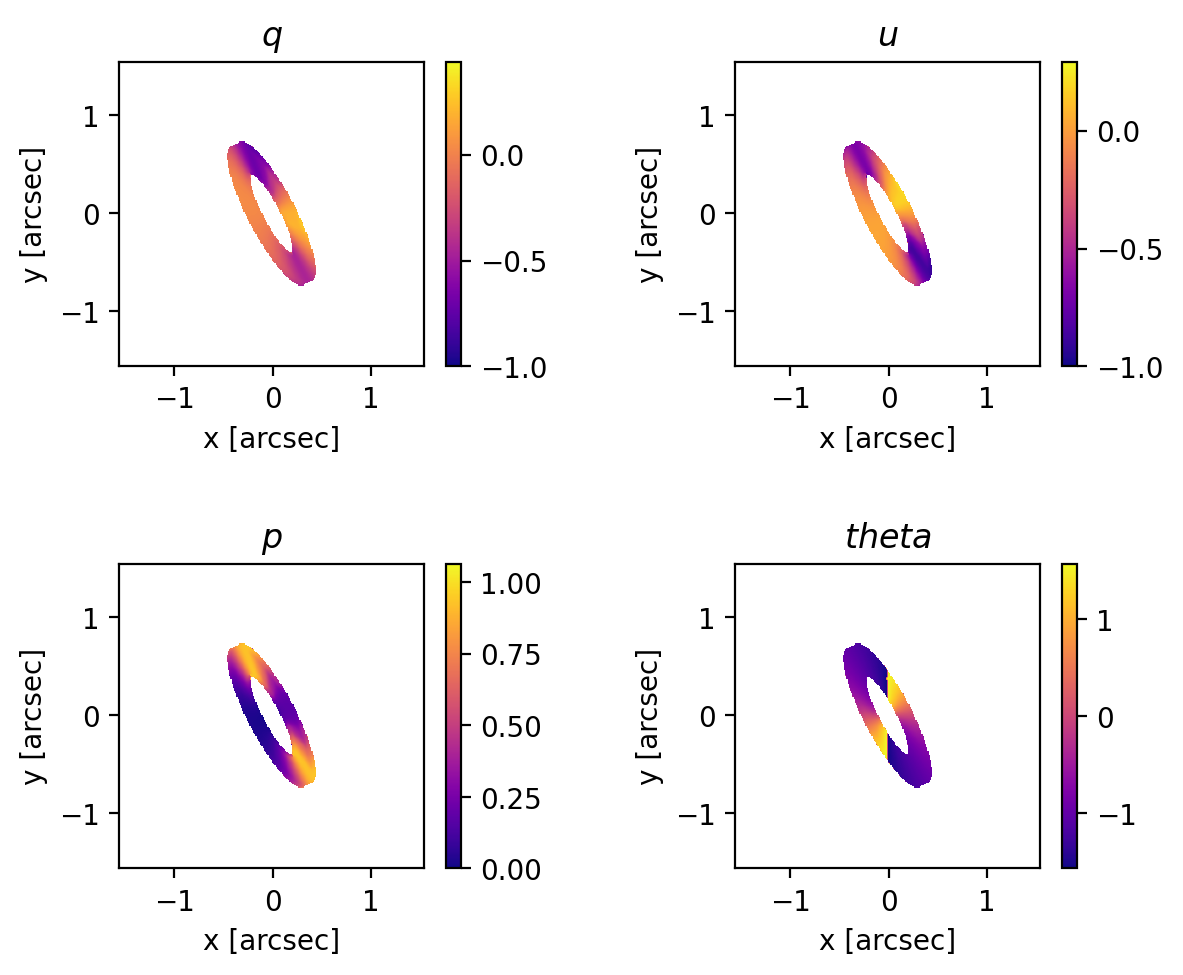

In [195]:
fig = plt.figure(dpi=200)
ax1=fig.add_subplot(221)
im1=ax1.imshow(q,cmap='plasma',extent=[np.min(xpix),np.max(xpix),np.max(ypix),np.min(ypix)])
ax1.invert_yaxis()
ax1.set_ylabel('y [arcsec]')
ax1.set_xlabel('x [arcsec]')
ax1.set_title('$q$')
cb = fig.colorbar(im1,orientation='vertical')
ax1.grid(False)

ax2=fig.add_subplot(222)
im2=ax2.imshow(u,cmap='plasma',extent=[np.min(xpix),np.max(xpix),np.max(ypix),np.min(ypix)])
ax2.invert_yaxis()
ax2.set_ylabel('y [arcsec]')
ax2.set_xlabel('x [arcsec]')
ax2.set_title('$u$')
cb = fig.colorbar(im2,orientation='vertical')
ax2.grid(False)

ax3=fig.add_subplot(223)
im3=ax3.imshow(p,cmap='plasma',extent=[np.min(xpix),np.max(xpix),np.max(ypix),np.min(ypix)])
ax3.invert_yaxis()
ax3.set_ylabel('y [arcsec]')
ax3.set_xlabel('x [arcsec]')
ax3.set_title('$p$')
cb = fig.colorbar(im3,orientation='vertical')
ax3.grid(False)

ax4=fig.add_subplot(224)
im4=ax4.imshow(theta,cmap='plasma',extent=[np.min(xpix),np.max(xpix),np.max(ypix),np.min(ypix)])
ax4.invert_yaxis()
ax4.set_ylabel('y [arcsec]')
ax4.set_xlabel('x [arcsec]')
ax4.set_title('$theta$')
cb = fig.colorbar(im4,orientation='vertical')
ax4.grid(False)
fig.subplots_adjust(hspace=0.65, wspace=0.4, top=0.95, right=0.95)